In [1]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(tidyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
# import ggplot theme
source("../../utils/figure_themes.r")

In [2]:
data_path <- file.path("..","..","data","5.converted_data","normalized_manual_feature_selected_output.parquet")

data <- arrow::read_parquet(data_path)
head(data)

Image_Count_ConvertImageToObjects,AreaShape_Area,AreaShape_Compactness,AreaShape_ConvexArea,AreaShape_Eccentricity,AreaShape_EquivalentDiameter,AreaShape_FormFactor,AreaShape_HuMoment_0,AreaShape_HuMoment_1,AreaShape_HuMoment_2,⋯,RadialDistribution_MeanFrac_OP_2of4,RadialDistribution_MeanFrac_OP_3of4,RadialDistribution_MeanFrac_OP_4of4,RadialDistribution_RadialCV_OP_1of4,RadialDistribution_RadialCV_OP_2of4,RadialDistribution_RadialCV_OP_3of4,RadialDistribution_RadialCV_OP_4of4,Metadata_genotype,Metadata_side,Metadata_identity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.8242748,1.7062336,-1.0946630,1.5267377,-0.3646179,1.6040166,1.301326483,-0.8505173,-0.6439171,-0.9304764,⋯,-1.4141814,-1.0813624,1.4725468,0.721203624,1.01933662,1.4136517,1.4325833,high,L,both
-0.8242748,0.7716744,-1.0749513,0.7539925,0.1690086,0.8928066,1.255925046,-0.6799504,-0.5736594,-0.9153793,⋯,-1.3369640,-1.5184304,1.6396414,1.061081351,0.23000074,0.7981232,1.3723331,high,R,both
-0.4672640,2.1808575,-0.2966127,2.4086201,-2.9373126,1.9237911,-0.006871006,-0.9334970,-0.7014174,-0.9479189,⋯,0.3330794,-0.4245064,-0.3254008,1.638487291,1.21338886,0.1522240,0.2303339,high,L,both
-0.8242748,2.0815568,-1.2143221,2.0253448,-0.8354232,1.8587312,1.598488818,-0.9152581,-0.6692863,-0.9750044,⋯,-1.3757325,-1.3668256,1.7823085,-0.433300716,-0.05436085,0.9076824,1.1385302,high,R,both
-0.1102533,0.6593682,-1.1889606,0.5044074,0.3919800,0.7977066,1.532220049,-0.5576464,-0.5116152,-0.7973963,⋯,-1.3117404,-1.1769029,1.3657797,0.003004767,0.40706654,1.0319502,1.0722050,high,L,both
-0.8242748,1.7431080,-1.1543990,1.6862199,-0.9851928,1.6297006,1.444849359,-0.9232483,-0.6741598,-0.9345940,⋯,-1.1755967,-0.8047828,1.1799261,-0.911442753,-0.58553633,0.3651254,0.6007558,high,R,both


In [3]:
# drop all metadata except for the genotype data 
features_df <- data %>% select(-c(contains("Metadata")))
features_df$Metadata_genotype <- data$Metadata_genotype
# get the variance of each feature per genotype
variance_df <- features_df %>% 
  group_by(Metadata_genotype) %>% 
  summarize_all(var) %>% 
  pivot_longer(cols = -Metadata_genotype, names_to = "feature", values_to = "variance")
head(variance_df)

Metadata_genotype,feature,variance
<chr>,<chr>,<dbl>
high,Image_Count_ConvertImageToObjects,0.5224711
high,AreaShape_Area,0.5167622
high,AreaShape_Compactness,0.7339399
high,AreaShape_ConvexArea,0.3648957
high,AreaShape_Eccentricity,1.6339921
high,AreaShape_EquivalentDiameter,0.3141811


In [4]:
# order the df by variance
variance_df <- variance_df %>% arrange(desc(variance))
head(variance_df)

Metadata_genotype,feature,variance
<chr>,<chr>,<dbl>
unsel,AreaShape_HuMoment_4,2.220865
unsel,Image_Count_ConvertImageToObjects,1.931026
unsel,AreaShape_HuMoment_5,1.707852
unsel,Neighbors_FirstClosestObjectNumber_Adjacnt,1.637217
high,AreaShape_Eccentricity,1.633992
unsel,AreaShape_HuMoment_3,1.626527


In [5]:

variance_df <- variance_df %>%
    dplyr::arrange(desc(abs(variance))) %>%
    tidyr::separate(
        feature,
        into = c(
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel) %>%
    dplyr::arrange(desc(abs(variance)))

variance_df <- variance_df %>%
    dplyr::group_by(feature_group, Metadata_genotype) %>%
    dplyr::slice_max(order_by = variance, n = 1)


Warning message:
“Expected 5 pieces. Missing pieces filled with `NA` in 195 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [6]:
head(variance_df)

Metadata_genotype,feature,feature_group,measurement,channel,parameter1,parameter2,variance,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
high,AreaShape_Eccentricity,AreaShape,Eccentricity,NA,NA,NA,1.6339921,NA
unsel,AreaShape_HuMoment_4,AreaShape,HuMoment,4,NA,NA,2.2208645,4
wt,AreaShape_HuMoment_1,AreaShape,HuMoment,1,NA,NA,1.4626959,1
high,Granularity_6_OP,Granularity,6,OP,NA,NA,0.9811988,OP
unsel,Granularity_1_OP,Granularity,1,OP,NA,NA,1.2021245,OP
wt,Granularity_2_OP,Granularity,2,OP,NA,NA,1.5196928,OP


In [7]:
# replace the Metadata_genotype with the actual genotype name
variance_df$Metadata_genotype <- gsub("high", "High-Severity", variance_df$Metadata_genotype)
variance_df$Metadata_genotype <- gsub("unsel", "Mid-Severity", variance_df$Metadata_genotype)
variance_df$Metadata_genotype <- gsub("wt", "Wild Type", variance_df$Metadata_genotype)
# factorize the genotype
variance_df$Metadata_genotype <- factor(variance_df$Metadata_genotype, levels = c("Wild Type", "Mid-Severity", "High-Severity"))
head(variance_df,2)

Metadata_genotype,feature,feature_group,measurement,channel,parameter1,parameter2,variance,channel_cleaned
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
High-Severity,AreaShape_Eccentricity,AreaShape,Eccentricity,NA,NA,NA,1.633992,NA
Mid-Severity,AreaShape_HuMoment_4,AreaShape,HuMoment,4,NA,NA,2.220865,4


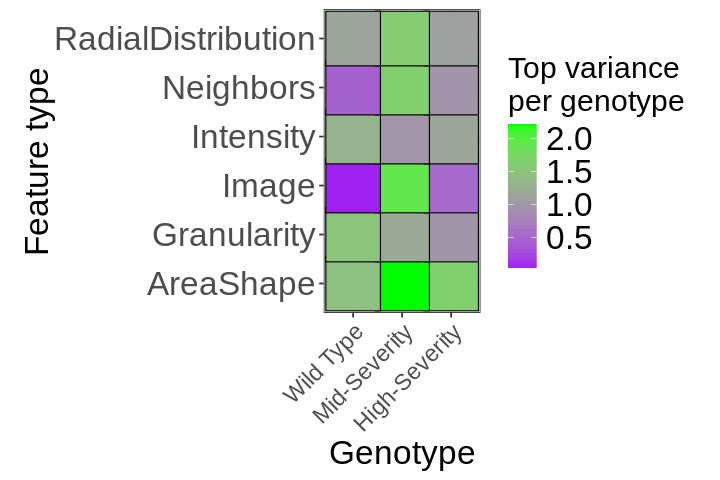

In [8]:
width <- 6
height <- 4
options(repr.plot.width=width, repr.plot.height=height)

coef_gg <- (
        ggplot(variance_df, aes(x = Metadata_genotype, y = feature_group))
        + geom_point(aes(fill = abs(variance)), pch = 22, size = 17)
        # + facet_wrap("~compartment", ncol = 3)
        + theme_bw()
        + scale_fill_continuous(
            name="Top variance \nper genotype",
            low = "purple",
            high = "green",
        )
        + xlab("Genotype")
        + ylab("Feature type")
        
        + figure_theme
        + theme(
            axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        )
        # rotate x axis labels
        + theme(axis.text.x = element_text(angle = 45, hjust = 1))
        + theme(plot.title = element_text(hjust = 0.5))
        + ggplot2::coord_fixed()
        )
coef_gg
# save the plot
ggsave(file="top_variance_per_genotype.png", plot=coef_gg, path= file.path("..","figures"), dpi=600, width=width, height=height, units="in", limitsize = FALSE)

### Feature types across genotypes and sides

In [9]:
head(data)

Image_Count_ConvertImageToObjects,AreaShape_Area,AreaShape_Compactness,AreaShape_ConvexArea,AreaShape_Eccentricity,AreaShape_EquivalentDiameter,AreaShape_FormFactor,AreaShape_HuMoment_0,AreaShape_HuMoment_1,AreaShape_HuMoment_2,⋯,RadialDistribution_MeanFrac_OP_2of4,RadialDistribution_MeanFrac_OP_3of4,RadialDistribution_MeanFrac_OP_4of4,RadialDistribution_RadialCV_OP_1of4,RadialDistribution_RadialCV_OP_2of4,RadialDistribution_RadialCV_OP_3of4,RadialDistribution_RadialCV_OP_4of4,Metadata_genotype,Metadata_side,Metadata_identity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.8242748,1.7062336,-1.0946630,1.5267377,-0.3646179,1.6040166,1.301326483,-0.8505173,-0.6439171,-0.9304764,⋯,-1.4141814,-1.0813624,1.4725468,0.721203624,1.01933662,1.4136517,1.4325833,high,L,both
-0.8242748,0.7716744,-1.0749513,0.7539925,0.1690086,0.8928066,1.255925046,-0.6799504,-0.5736594,-0.9153793,⋯,-1.3369640,-1.5184304,1.6396414,1.061081351,0.23000074,0.7981232,1.3723331,high,R,both
-0.4672640,2.1808575,-0.2966127,2.4086201,-2.9373126,1.9237911,-0.006871006,-0.9334970,-0.7014174,-0.9479189,⋯,0.3330794,-0.4245064,-0.3254008,1.638487291,1.21338886,0.1522240,0.2303339,high,L,both
-0.8242748,2.0815568,-1.2143221,2.0253448,-0.8354232,1.8587312,1.598488818,-0.9152581,-0.6692863,-0.9750044,⋯,-1.3757325,-1.3668256,1.7823085,-0.433300716,-0.05436085,0.9076824,1.1385302,high,R,both
-0.1102533,0.6593682,-1.1889606,0.5044074,0.3919800,0.7977066,1.532220049,-0.5576464,-0.5116152,-0.7973963,⋯,-1.3117404,-1.1769029,1.3657797,0.003004767,0.40706654,1.0319502,1.0722050,high,L,both
-0.8242748,1.7431080,-1.1543990,1.6862199,-0.9851928,1.6297006,1.444849359,-0.9232483,-0.6741598,-0.9345940,⋯,-1.1755967,-0.8047828,1.1799261,-0.911442753,-0.58553633,0.3651254,0.6007558,high,R,both


In [10]:
# drop all metadata except for the genotype data 
features_df <- data %>% select(-c(contains("Metadata")))
features_df$Metadata_genotype <- data$Metadata_genotype
features_df$Metadata_side <- data$Metadata_side
# get the variance of each feature per genotype and side
variance_df <- features_df %>% 
  group_by(Metadata_genotype, Metadata_side) %>% 
  summarize_all(var) %>% 
  pivot_longer(cols = -c(Metadata_genotype, Metadata_side), names_to = "feature", values_to = "variance")
# replace the Metadata_genotype with the actual genotype name
variance_df$Metadata_genotype <- gsub("high", "High-Severity", variance_df$Metadata_genotype)
variance_df$Metadata_genotype <- gsub("unsel", "Mid-Severity", variance_df$Metadata_genotype)
variance_df$Metadata_genotype <- gsub("wt", "Wild Type", variance_df$Metadata_genotype)
# factorize the genotype
variance_df$Metadata_genotype <- factor(variance_df$Metadata_genotype, levels = c("Wild Type", "Mid-Severity", "High-Severity"))
head(variance_df,2)

Metadata_genotype,Metadata_side,feature,variance
<fct>,<chr>,<chr>,<dbl>
High-Severity,L,Image_Count_ConvertImageToObjects,0.8718876
High-Severity,L,AreaShape_Area,0.6178017


In [11]:
# order the df by variance
variance_df <- variance_df %>% arrange(desc(variance))
head(variance_df)

Metadata_genotype,Metadata_side,feature,variance
<fct>,<chr>,<chr>,<dbl>
Mid-Severity,L,Image_Count_ConvertImageToObjects,3.259753
Mid-Severity,L,AreaShape_HuMoment_4,2.830132
Mid-Severity,L,Neighbors_FirstClosestObjectNumber_Adjacnt,2.485417
Mid-Severity,R,RadialDistribution_FracAtD_OP_1of4,2.470214
Mid-Severity,R,AreaShape_HuMoment_5,2.365691
Mid-Severity,R,AreaShape_Perimeter,2.283383


In [12]:

variance_df <- variance_df %>%
    dplyr::arrange(desc(abs(variance))) %>%
    tidyr::separate(
        feature,
        into = c(
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel) %>%
    dplyr::arrange(desc(abs(variance)))

variance_df <- variance_df %>%
    dplyr::group_by(feature_group, Metadata_genotype, Metadata_side) %>%
    dplyr::slice_max(order_by = variance, n = 1)


Warning message:
“Expected 5 pieces. Missing pieces filled with `NA` in 390 rows [1, 2, 3, 4, 5,
6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


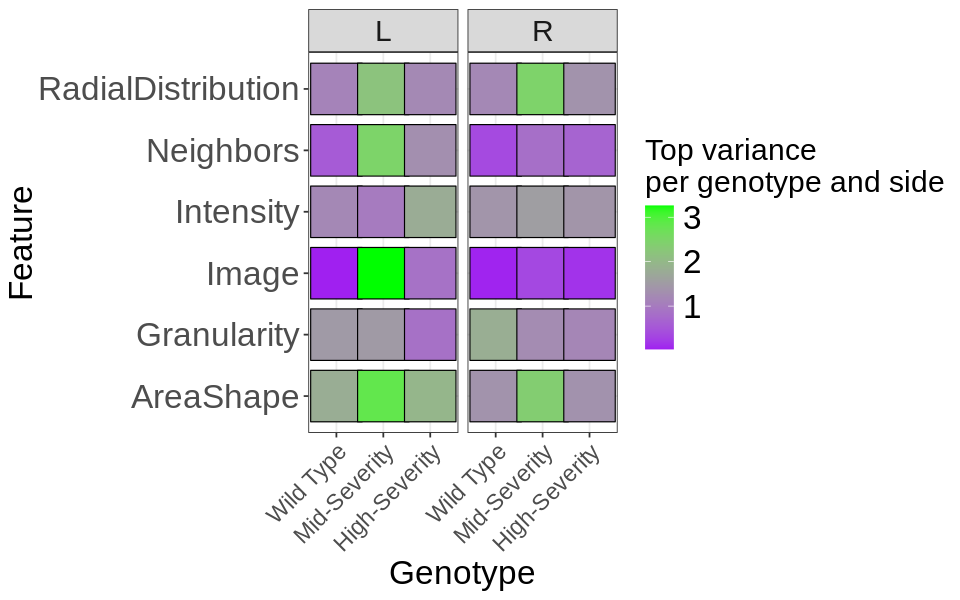

In [15]:
width <- 8
height <- 5
options(repr.plot.width=width, repr.plot.height=height)

coef_gg <- (
        ggplot(variance_df, aes(x = Metadata_genotype, y = feature_group))
        + geom_point(aes(fill = abs(variance)), pch = 22, size = 16)
        # + facet_wrap("~compartment", ncol = 3)
        + theme_bw()
        + scale_fill_continuous(
            name="Top variance \nper genotype and side",
            low = "purple",
            high = "green",
        )
        + xlab("Genotype")
        + ylab("Feature")
        
        + figure_theme
        + theme(
            axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        )
        # rotate x axis labels
        + theme(axis.text.x = element_text(angle = 45, hjust = 1))
        + theme(plot.title = element_text(hjust = 0.5))
        # + ggplot2::coord_fixed()
        + facet_wrap(~Metadata_side)
        )
coef_gg
# save the plot
ggsave(file="top_variance_per_genotype_and_side.png", plot=coef_gg, path= file.path("..","figures"), dpi=600, width=width, height=height, units="in", limitsize = FALSE)

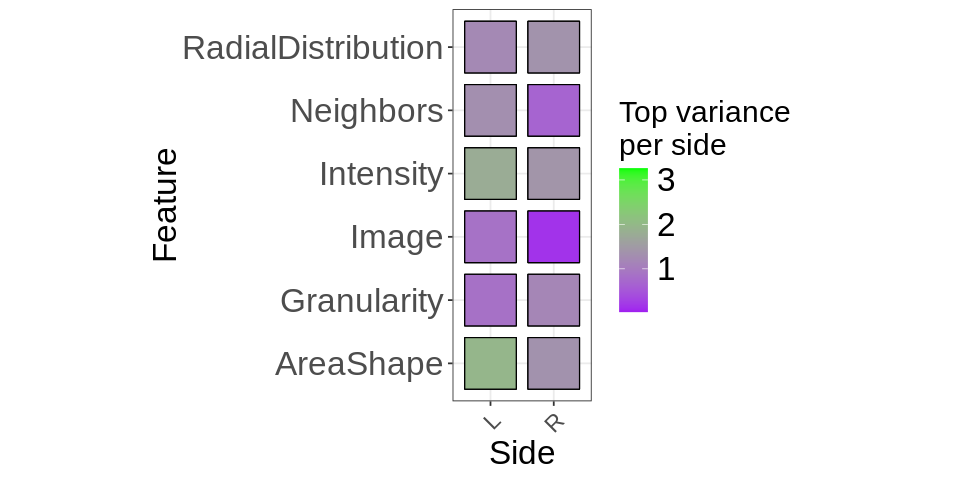

In [14]:
width <- 8
height <- 4
options(repr.plot.width=width, repr.plot.height=height)

coef_gg <- (
        ggplot(variance_df, aes(x = Metadata_side, y = feature_group))
        + geom_point(aes(fill = abs(variance)), pch = 22, size = 16)
        # + facet_wrap("~compartment", ncol = 3)
        + theme_bw()
        + scale_fill_continuous(
            name="Top variance \nper side",
            low = "purple",
            high = "green",
        )
        + xlab("Side")
        + ylab("Feature")
        
        + figure_theme
        + theme(
            axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        )
        # rotate x axis labels
        + theme(axis.text.x = element_text(angle = 45, hjust = 1))
        + theme(plot.title = element_text(hjust = 0.5))
        + ggplot2::coord_fixed()
        )
coef_gg
# save the plot
ggsave(file="top_variance_per_side.png", plot=coef_gg, path= file.path("..","figures"), dpi=600, width=width, height=height, units="in", limitsize = FALSE)